# Pytorch 官方文档笔记
------------------------------------------------翻译自pytorch文档------------------------------------------------
<style>
img{
    width: 60%;
    padding-left: 20%;
}
</style>
## 编写自定义数据集，数据加载器和转换
Author: Sasank Chilamkurthy

翻译：小溜蛇

这一节讲述，如何使用pytorch加载，处理和增强自定义数据

还需要安装以下packages:

- scikit-image: 读取图片和转换图片数据
- pandas: 读取表格

让我们先载入需要的库

In [1]:
from __future__ import print_function, division
import os # 读取文件
import torch 
import pandas as pd # 读取表格
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt # 绘图
from torch.utils.data import Dataset, DataLoader # DataLoader是批量存放数据和标签的容器
from torchvision import transforms, utils # 转换图片数据

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

我们以面部姿势数据为例。每张脸拥有68个标记点

![](https://pytorch.org/tutorials/_images/landmarked_face2.png)

- [下载](https://download.pytorch.org/tutorial/faces.zip)数据集到本地
  数据集包括人脸图片与存储于表格中到标记点数据

让我们快速预览标记点数据吧 😊

In [3]:
landmarks_frame = pd.read_csv('./faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0] # 第n列的第一个数据是图片的名字
landmarks = landmarks_frame.iloc[n, 1:] # 剩下的是标注点数据
landmarks = np.asarray(landmarks) # 将标注点数据转化为numpy数组
landmarks = landmarks.astype('float').reshape(-1, 2) # 将numpy数组转化成每行两列的数组

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


将人脸图片和标注点合并展示

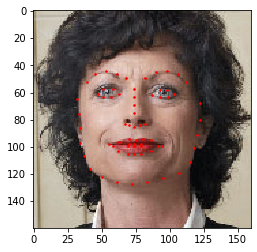

In [4]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r') # 第一列代表x轴坐标，第二列代表y轴坐标
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(os.path.join('./faces/', img_name)),
               landmarks)
plt.show()


## 建立自定义数据库
torch.utils.data.Dataset 是非常好用的数据读取工具。我们可以依照它的结构，建立自定义数据库。
其中包含两个功能：

- __len__ 读取数据总量
- __getitem__ 根据索引读取图片数据


In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args（参数）:
            csv_file (string): 表格数据路径
            root_dir (string): 包含图片的文件夹路径.
            transform (callable, optional): 是否将图片转化成numpy数组
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame) # 数据总量

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # convert the index into a List. 将索引存放进list

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

让我们来测试一下吧

0 (324, 215, 3) (68, 2)


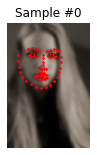

1 (500, 333, 3) (68, 2)


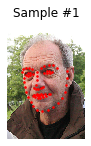

2 (250, 258, 3) (68, 2)


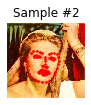

3 (434, 290, 3) (68, 2)


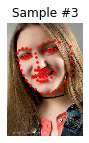

In [26]:
face_dataset = FaceLandmarksDataset(csv_file='./faces/face_landmarks.csv',
                                    root_dir='./faces/')

fig = plt.figure()


for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(141+i)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    

    if i == 3:
        plt.show()
        break


## Transform

我们可以看到，输出结果显示每张图片的形状不一样。而神经网络通常需要固定的输入，所以我们要对图片进行处理。

- Rescale: to scale the image 调整图片形状
- RandomCrop: to crop from image randomly. 裁剪出任意的一块
- ToTensor: to convert the numpy images to torch images (we need to swap axes).将 numpy 数组转化为Tensor


In [28]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        # 此时的numpy数组为 高*宽*通道数
        # 而 tensor的顺序为 通道数*高*宽
        # （2，0，1）是将原来的第0位变成第2位，第1位变成第0位，第2位变成第1位
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}


transforms.Compose() 可以实现一连串地对图片的调整，如果你对图片处理很复杂，这个函数可以让你的代码更加简洁。

单个操作用list包裹起来，

e.g. 
> transforms.Compose([transforms.CenterCrop(10), transforms.ToTensor()])

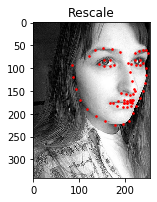

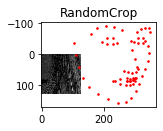

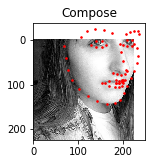

In [29]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[20]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

